# fMRI prepreprocessing - Hands-on session Part I

#### Max Planck School of Cognition, Methods in Cognitive Neuroscience, July 2021


##### Contact: Frauke Beyer @ Neurology Dept., MPI CBS, Leipzig, Germany, fbeyer@cbs.mpg.de

###### Please contact me if you have any questions or problems with the notebook! I'm happy to help :)

### Objectives

Preprocessing of functional MRI data is an important step in analyzing both task-based and resting state fMRI studies.  
In this notebook, we will cover the main steps of fMRI preprocessing.  
You will
* learn how to plot and inspect fMRI data in python
* implement main preprocessing steps for fMRI data
* find out how to use `nipype` to embed different preprocessing steps

In this [OHBM OnDemand How-to: Resting State fMRI Analysis](https://www.ohbmbrainmappingblog.com/blog/ohbm-ondemand-how-to-resting-state-fmri-analysis) you find some more "hands-on" recommendations to guide you through the jungle of rs-fMRI preprocessing and analysis options. For a general introduction to the most important preprocessing steps for fMRI, see [Ashburner, 2009](https://link.springer.com/protocol/10.1007/978-1-60327-919-2_6), for a more extensive coverage of preprocessing, especially for resting state fMRI, see [Caballero-Gaudes, 2017](https://www.sciencedirect.com/science/article/pii/S1053811916307418). 

### Packages

We will use one software package and different python packages in this hands-on session:
* <a href='fsl.fmrib.ox.ac.uk/'>FSL</a> is an open-source neuroimaging toolbox which is very common and extremely versatile. In FSL, you can do  task-based and resting state functional MRI analyses, as well as structural and diffusion MRI. You can find an overview of its functions and tutorials on the homepage. 

* [nipype](https://nipype.readthedocs.io/) is a Python project that provides a uniform interface to existing neuroimaging software and facilitates interaction between these packages within a single workflow. With Nipype you can integrate algorithms from different packages (e.g., ANTS, SPM, FSL, FreeSurfer, Camino, MRtrix, MNE, AFNI, Slicer, DIPY), into a single workflow which has many advantages in terms of flexibility, run time, reproducibility... 

* [nibabel](https://nipy.org/nibabel/) is a Python project which enables the handling of NIFTI-files, the most common format for MRI data, in python

* [nilearn](https://nilearn.github.io/) is a package for fast and easy statistical learning on NeuroImaging data.

* As Mina already introduced, all these packages make extensive use of Numpy (and Scipy). In case you have never worked with Numpy and you are interested to learn it, there are some notebooks on Minas <a href='https://github.com/minajamshidi/Python-Tutorials/tree/master/Numpy%20tutorials'>GitHub</a>, which could be used as a playground for exploring Numpy.


### Data
In the hands-on sessions, we will primarily use fMRI and T1w data from `sub-160563d` located in `./fMRI_data`. The subject participated in the LIFE-Upgrade study at the MPI CBS and agreed on sharing his/her data. 
The other dataset in the folder `subj-010088` comes from the [LEMON Study](https://www.nature.com/articles/sdata2018308), a public dataset collected at the MPI CBS. You can also try out the analysis steps with this subject if you like.
I included both MRI datasets in the repository, and you automatically have them in the `fMRI_data` folder. 

### Packages
#### FSL
[FSL](https://www.fmrib.ox.ac.uk/fsl) is a neuroimaging software package which includes many functions useful for preprocessing and analysis of fMRI.  
It has been installed for us on the jupyter-hub in `home/jovyan/public-ro/Course_MCN_2021/fsl`. We have to add the path to the FSL binaries into our path and make the FSL directory known to our local environment. This step has to be performed every time we use the notebook.

In [2]:
import os
import getpass
os.environ["PATH"] += os.pathsep + "/home/" + getpass.getuser() + "/public-ro/Course_MCN_2021/fsl/bin"
os.environ["FSLDIR"] = "/home/" + getpass.getuser() + "/public-ro/Course_MCN_2021/fsl/"
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"

To run commands in the shell from your notebook, use a "!" in front of the command.

In [3]:
#Test whether your FSL installation worked by typing
!echo $FSLDIR #should give you the location of your installation
!mcflirt #should return description of the function

/home/jovyan/public-ro/Course_MCN_2021/fsl/
Usage: mcflirt -in <infile> [options]

  Available options are:
        -out, -o <outfile>               (default is infile_mcf)
        -cost {mutualinfo,woods,corratio,normcorr,normmi,leastsquares}        (default is normcorr)
        -bins <number of histogram bins>   (default is 256)
        -dof  <number of transform dofs>   (default is 6)
        -refvol <number of reference volume> (default is no_vols/2)- registers to (n+1)th volume in series
        -reffile, -r <filename>            use a separate 3d image file as the target for registration (overrides refvol option)
        -scaling <num>                             (6.0 is default)
        -smooth <num>                      (1.0 is default - controls smoothing in cost function)
        -rotation <num>                    specify scaling factor for rotation optimization tolerances
        -verbose <num>                     (0 is least and default)
        -stages <number of search le

### Packages
#### python-based packages
Now, we install `nipype 1.6.0`, `nibabel 2.5.2`, `nilearn 0.8.0`, `nipy 0.5.0`, `nitime 0.9` and `joblib 1.0.1` via `!pip install --user ...`. Again, we perform the installation with the ! directly from our notebook. 
The installation has to be done only once (so if you installed the packages during the EEG tutorial, you do not need to re-install them). Loading the packages has to be performed everytime you use the notebook.

In [4]:
!pip install --user nipype==1.6.0
!pip install --user nibabel==2.5.2
!pip install -U --user nilearn==0.8.0
!pip install -U --user joblib==1.0.1
!pip install --user nitime==0.9
!pip install nipy==0.5.0

  Using cached nibabel-2.5.2-py3-none-any.whl (3.3 MB)
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.2.1
    Uninstalling nibabel-3.2.1:
      Successfully uninstalled nibabel-3.2.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 4.9 MB 4.0 MB/s eta 0:00:01
  Attempting uninstall: nilearn
    Found existing installation: nilearn 0.7.1
    Uninstalling nilearn-0.7.1:
      Successfully uninstalled nilearn-0.7.1
  Using cached nipy-0.5.0-cp38-cp38-manylinux1_x86_64.whl (2.3 MB)


Now we import these packages, along with numpy and scipy and check their versions.

In [5]:
import nipype
print("nipype version %s" %nipype.__version__)
import nibabel as nib
print("nibabel version %s" %nib.__version__)
import nilearn as nil
print("nilearn version %s" %nil.__version__)

nipype version 1.6.0
nibabel version 2.5.2
nilearn version 0.8.0


/home/jovyan/.local/lib/python3.8/site-packages/nilearn/__init__.py:75: FutureWarning: Support for Nibabel 2.x is deprecated and will stop in release 0.9.0. Please consider upgrading to Nibabel 3.x.
  _nibabel_deprecation_warnings()


In [7]:
import numpy as np
print("numpy version %s" %np.__version__)
import scipy
print("scipy version %s" %scipy.__version__)

numpy version 1.16.6
scipy version 1.6.3


We give shorter names to the fMRI dataset, so we can use it more easily.

In [10]:
func="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/func/sub-160563d_task-rest_bold.nii.gz"
#func="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-010088/sub-010088_ses-01_task-rest_acq-AP_run-01_bold.nii.gz"

### Plotting
First, we load the `matplotlib` package.

In [11]:
import matplotlib.pyplot as plt

In order to be able to run interactive matplotlib plots in jupyter hub, we have to set the backend of the matplotlib package to notebook. This can be achieved by:

    %matplotlib notebook

Note: If you are running the notebook on your local machine, the backend tk is prefered. You can set it by:

    %matplotlib tk
    
In order to go back to inline plotting, you can write:

    %matplotlib inline

For more tips & tricks on how to best plot interactively in jupyter notebooks, I found [this](https://medium.com/@1522933668924/using-matplotlib-in-jupyter-notebooks-comparing-methods-and-some-tips-python-c38e85b40ba1) page quite helpful.

In [16]:
#matplotlib notebook
%matplotlib inline

### Loading the data
To load the data, we use nibabel's `load` function. This function converts the data from the [NIFTI-format]() into a `Nifti1Image` python object.   

A nibabel `Nifti1Image` object is the association of three things:  
* an numpy N-D array containing the image data;
* a (4, 4) affine matrix which specifies the orientation of the image
* image metadata in the form of a header.

Many functions from python neuroimaging packages such as `nilearn` and `nipy` directly operate on the `Nifti1Image`. Yet, you can also extract the `numpy` array from the object and directly modify this array.   



The affine matrix of the nibabel `Nifti1Image` maps the numpy-array to the anatomical or patient coordinate system. This coordinate system is orthogonal and oriented along the main axes of the participant. In a RAS+ coordinate system, the X (or first dimension of the numpy array) describes the **r**ight->left axis, Y refers to **a**nterior-> posterior, and Z **s**uperior-inferior. For more information on imaging coordinate systems, please see [here](https://www.slicer.org/wiki/Coordinate_systems).

In [13]:
# Now we load the nifti of the functional scan into a nibabel image object
img_func = nib.load(func)

#### Exercise 1
Find out about the image dimensions and total duration of this scan. You can use the built-in methods
(or functions) of the nibabel image-object `.shape` and `.header` described [here](https://nipy.org/nibabel/gettingstarted.html) and the nibabel methods for reading the image header [here](https://nipy.org/nibabel/nibabel_images.html).

### Visualization
Visualizing the data is always very helpful to get a feeling for the data and notice mistakes. As you saw in the exercise above, the fMRI data has several hundred volumes, i.e. imaging timepoints. This means we can either go through volumes over time, display one out of these volumes, or show the mean image.   
Going through the fMRI data over time is most easily done in 3D visualization software such as `fsleyes` or `freeview`.  
Unfortunately, these visualization tools cannot be used in the jupyter notebook. Instead, we can use `nilearn` to view the brain images or simple `matplotlib` plotting commands to scroll through the images interactively. 


#### Use FSLEYES to view fMRI timeseries
I will demonstrate this on a local server.

#### Use nilearn to plot the mean image

In [14]:
# Let's calculate the mean image
# We do this by taking the mean along the 4th dimension
from nilearn.image.image import mean_img
mean_func = mean_img(func)
mean_func.to_filename('./fMRI_data/sub-160563d/func/mean_func_raw.nii.gz')


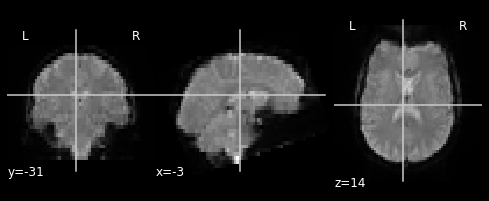

In [17]:
# Visualization of the fMRI in orthogonal slices (with nilearn)
from nilearn.plotting import plot_epi,show
plot_epi(mean_func,cmap="gray")

#### Use matplotlib to plot any slice of the 4D image array

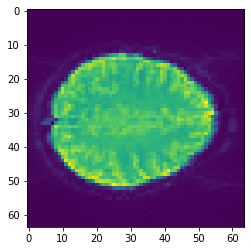

In [18]:
# Visualization of the fMRI (with numpy array & matplotlib)

img_func_data = img_func.get_fdata()

# We have to select 2 dimensions from the 4D data set to be able to plot it in 2D with imshow.

# With this command, we plot the 41st axial slice of the second timepoint
# Remember that python starts to enumerate from 0!
plt.imshow(img_func_data[:,:,20,1])

#with gray colormap this looks more like a brain: 
#plt.imshow(img_func_data[:,:,20,1], cmap='gray')

#### Use a function to interactively plot the 4D fMRI data

We can use the package `ipywidgets` to create sliders which allow us to interactively modify a function. Here, we first define the function `plot_slice` to plot a single slice of the image (in the z, so inferior/superior, direction and at a single timepoint). Then, we create a second function `z_vol_viewer` in which we can interactively modify the slice and the timepoint with a slider.

In [19]:
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
#,tp
def plot_slice(volume,z,vol):
    plt.imshow(volume[:,:,z,vol].T, cmap="gray")
    plt.show()

def z_vol_viewer(img):
    interact(plot_slice, volume=fixed(img), 
             z = widgets.IntSlider(value=img.shape[2]//2,
                                   min=0,
                                   max=img.shape[2]-1,
                                   step=1,
                                   description="z-axis"),
             vol = widgets.IntSlider(value=0,
                                     min=0,
                                     max=img.shape[3]-1,
                                     step=1,
                                     description="volume"),
            )

z_vol_viewer(img_func_data)

interactive(children=(IntSlider(value=15, description='z-axis', max=29), IntSlider(value=0, description='volum…

### Exercise 2 
Plot a sagital and coronal slice for volume 100. If you feel like it, you can try to create a truely 3D/4D viewer by copying and then extending the function `z_vol_viewer` above.

Now let's inspect the time dimension of the fMRI data. To do so, we will plot the raw time series of two voxels (selected from the "middle" of the brain based on the plots above) by subsetting the `img_func_data` Numpy array. Try to play around with the voxel locations and compare the signal intensity and time courses.

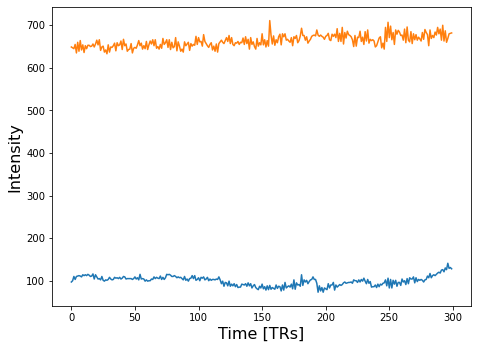

In [20]:
plt.figure(figsize=(7, 5))
plt.plot(img_func_data[32,58,15, :])
plt.plot(img_func_data[24,30,10, :])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
#plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)
plt.show()

## Preprocessing   
Now that we have inspected our data, we can start preprocessing it. This means we prepare the data to be statistically analyzed by removing confounds and error variance.
(Resting state) fMRI preprocessing involves many steps, and research groups tend to do it "their own way" - by using specific software packages and algorithms, leaving out certain steps or choosing different parameters. This contributes to the relatively low reproducibility of neuroimaging research (see [Nature paper](https://www.nature.com/articles/s41586-020-2314-9) on the [NARPS](https://www.narps.info/) project). 
Here, we would like to show you the "core" preprocessing steps that are largely agreed upon in the community (and implemented in [fMRIprep](https://www.nature.com/articles/s41592-018-0235-4?proof=trueIn), a software aiming to standardize fMRI preprocessing).

### Preprocessing steps
1. [ ] realignment of volumes to first or reference volume and extraction of motion parameters
2. [ ] skull stripping
- *slice time correction (used only for high TR and single-band acquisition)*
- *susceptibility distortion correction (recommended but not covered here)*
3. [ ] Denoising (removal of physiological and head motion-related noise)
4. [ ] Co-registration of fMRI to structural MRI **-> will be covered in 2nd hands-on-session**
5. [ ] Temporal filtering (removal of linear trend) **-> will be covered in 2nd hands-on-session**
6. [ ] Smoothing **-> will be covered in 2nd hands-on-session**

### Integration of different software packages with nipype
To perform the preprocessing steps, we have a large variety of neuroimaging software packages (FSL, Freesurfer, AFNI, SPM, nipy, ANTS ...) at our disposal. However, combining software from different packages in a clever and reproducible way is a big challenge.   
Here, `nipype` comes very handy: this python package provides a uniform interface to existing neuroimaging software and allows us to efficiently combine different software packages, dedicated python packages and our own functions. At first, it may seem a bit unintuitive to work with this 'overlay', yet, later it makes your life much easier by offering structure, adaptibility and scalability. Another advantage of learning `nipype` is that `fmriprep` and other recent software developments for reproducible neuroscience relie on its concepts. 

**nipype in a nutshell**  
[workflows](https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html) are the main feature of `nipype`. Workflows allow the intergration of different functions (from neuroimaging toolboxes or self-written) and the efficient computational execution of complex pipelines.  
[nodes](https://miykael.github.io/nipype_tutorial/notebooks/basic_nodes.html) are the building blocks of workflows and objects which execute a certain function. This function can be anything from a Nipype interface (wrapping an external algorithm) to a user-specified function or an external script.   
[interfaces](https://miykael.github.io/nipype_tutorial/notebooks/basic_interfaces.html) wrap a single command from various external packages (e.g. FSL, SPM or FreeSurfer), even if they themselves are written in another programming language than python. 
In the following, you will get to know the some of these concepts, but for a more complete introduction and explanation, please see the links to the great tutorials by [mykael](https://miykael.github.io/nipype_tutorial/).

### 1. Realignment 
During the fMRI scan, participants frequently move their heads. This head motion can either be a slight drift, i.e. lowering the chin to the chest, or single abrupt head movements, for example when the subject awakes from a brief nap. Therefore, the first preprocessing step is the realignment or motion correction of the scan. This operation aims to coregister all functional volumes to a common reference (oftentimes the first or middle volume), thereby aligning each voxel with itself over time. 
Here, we use the `MCFLIRT` [program](https://nipype.readthedocs.io/en/1.5.0/api/generated/nipype.interfaces.fsl.preprocess.html#mcflirt) from FSL for motion correction.  
First, we execute this command directly with `bash`.

In [21]:
#Use bash to run MCFLIRT
!mcflirt -in ./fMRI_data/sub-160563d/func/sub-160563d_task-rest_bold.nii.gz -out ./fMRI_data/sub-160563d/func/sub-160563d_task-rest_bold_mcf.nii.gz -plots

#### Exercise 3: which volume is used as reference volume by MCFLIRT and how can you change this parameter?
Hint: Check the manual of the command MCFLIRT

In [ ]:
!mcflirt

Now, we will use  `nipype` to wrap the command in an interface. First, we load the interface for FSL from `nipype.interfaces.fsl`. 

In [22]:
#Load nipype interface for FSL
import nipype.interfaces.fsl as fsl
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

Then, we define the input (`inputs.in_file`) and options (`save_plots=True`) for the interface.   
We can see the commandline which is executed with the command `run` by printing `mcflrt.cmdline`. We see that it is essentially the same command as we wrote in bash before. 
The result ist saved in a python results-object, and can be assessed via `outputs`.

In [23]:
#Run spatial realignment 
mcflrt= fsl.MCFLIRT(save_plots=True) #define the interface and tell it to save plots
mcflrt.inputs.in_file = func #define input to the interface
mcflrt.inputs.out_file= './fMRI_data/sub-160563d/func/rest_mcf.nii.gz'
print(mcflrt.cmdline) #show the commandline which is created by this interface
mcflrt_res = mcflrt.run() #run the interface, i.e. command line
par_file=mcflrt_res.outputs.par_file #extract the parameter file from the result object

mcflirt -in /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/sub-160563d_task-rest_bold.nii.gz -out fMRI_data/sub-160563d/func/rest_mcf.nii.gz -plots


In [24]:
print(mcflrt_res.outputs) #show the outputs of this node


mat_file = <undefined>
mean_img = <undefined>
out_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf.nii.gz
par_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf.nii.gz.par
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>



##### A Comment
<font color='gray'>

If you have completed the larger preprocessing steps once (and the outputs are located in `/fMRI_data/sub-160563d/func`), you don't have to run these steps again and instead refer to the full paths of the outputs in the upcomping preprocessing steps. 

## 2. Skull stripping
### Create the mean image of motion corrected fMRI data
To calculate the mean of the motion corrected fMRI data, we could do it as above and re-use the nilearn function `mean_img`. But we would like to get into `nipype` and so we employ a `FSL` tool wrapped in `nipype`.   
The interface `ImageMaths` wraps the FSL command `fslmaths`, a versatile tool to perform voxel-wise calculations. The option `Tmean` calculates the 4D mean of the fMRI data.  
Below, we define the interface and define its input (`in_file`), output name (`out_file`) and the `Tmean` option. 

In [25]:
# Calculate mean motion corrected fMRI
mean_mcf_interface = fsl.ImageMaths(in_file="./fMRI_data/sub-160563d/func/rest_mcf.nii.gz",#mcflrt_res.outputs.out_file, #use output of previous interface as input
                      out_file="./fMRI_data/sub-160563d/func/rest_mcf_mean_interface.nii.gz",
                      op_string= '-Tmean')
res_mean_mcf_interface=mean_mcf_interface.run()

The same command can be wrapped with a Nipype `node`. This is an extension of the interface concept, making it possible to combine more operations in a workflow. 

In [26]:
# Import the Node module
from nipype import Node

# Create Node
mean_mcf_node = Node(fsl.ImageMaths(),
                name='mean_mcf_node')
mean_mcf_node.inputs.in_file='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf.nii.gz'
mean_mcf_node.inputs.out_file='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_node.nii.gz'
mean_mcf_node.inputs.op_string="-Tmean"
res_mean_mcf_node=mean_mcf_node.run()

210610-07:33:54,422 nipype.workflow INFO:
	 [Node] Setting-up "mean_mcf_node" in "/tmp/tmpn5zc9r28/mean_mcf_node".
210610-07:33:54,433 nipype.workflow INFO:
	 [Node] Running "mean_mcf_node" ("nipype.interfaces.fsl.utils.ImageMaths"), a CommandLine Interface with command:
fslmaths /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf.nii.gz -Tmean /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_node.nii.gz
210610-07:33:55,977 nipype.workflow INFO:
	 [Node] Finished "mean_mcf_node".


We can plot the two (identical) results using `plot_epi`:

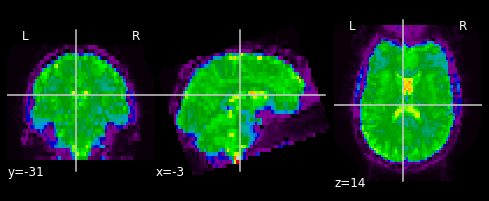

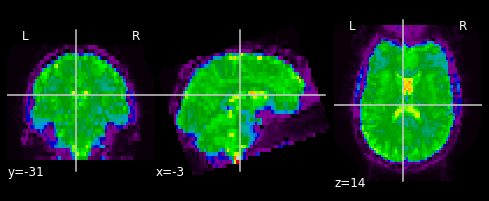

In [27]:
#if you ran the commands above:
plot_epi(res_mean_mcf_interface.outputs.out_file)
plot_epi(res_mean_mcf_node.outputs.out_file)

#if you ran the commands before and have pre-computed data:
#plot_epi("./fMRI_data/sub-160563d/func/rest_mcf_mean_interface.nii.gz")
#plot_epi("./fMRI_data/sub-160563d/func/rest_mcf_mean_node.nii.gz")

### Perform the skull stripping

Until now, our fMRI data still includes skull and neck areas. For further processing, we would like to extract the signal coming exclusively from the brain. Therefore, we have to perform skull stripping and create a brain mask from the mean image created above. This can be achieved with the function BET in FSL, wrapped in [nipype](https://nipype.readthedocs.io/en/1.5.0/api/generated/nipype.interfaces.fsl.preprocess.html#bet) 

In [28]:
bet=fsl.BET(mask=True)
bet.inputs.in_file="./fMRI_data/sub-160563d/func/rest_mcf_mean_node.nii.gz"#res_mean.outputs.out_file
bet.inputs.out_file = "./fMRI_data/sub-160563d/func/rest_mcf_mean_brain.nii.gz"
bet_res=bet.run()

In [25]:
print(bet_res.outputs)


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>



Alternatively, we can use the `compute_epi_mask` function in nilearn.

In [29]:
from nilearn.masking import compute_epi_mask
mask_img = compute_epi_mask(func)

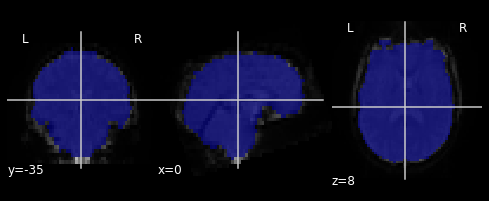

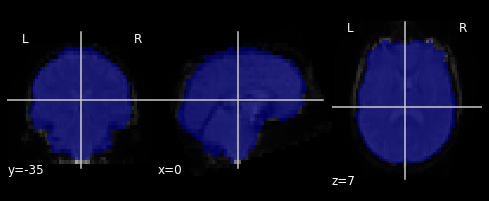

In [30]:
# Plot the brain mask overlaid with the functional image
from nilearn.plotting import plot_roi
plot_roi(mask_img, res_mean_mcf_interface.outputs.out_file)
plot_roi(bet_res.outputs.mask_file, res_mean_mcf_interface.outputs.out_file)

The mask created with BET looks slightly better as it does not exclude so many voxels in the medial OFC. On the other hand, it seems to include skull in some parts of the brain (e.g. near visual cortex).

## 3. Denoising
Functional MRI signal can be confounded by different non-neuronal noise sources (including slow scanner drift, instrument noise, head motion, respiration, cardiac pulsation). 
For a detailed review of the possible sources of noise in the BOLD signal, please see [this publication](https://link.springer.com/article/10.1007%2Fs11336-012-9294-0).  
In task-based fMRI, the BOLD signal is evaluated in reference to an external stimulus, and thus is less susceptible to the effects of unstructured noise. Yet, noise confounds are usually added to the task regressors in the 1st-level analysis.
In resting state fMRI there is no external reference and therefore noise may introduce spurious correlations between brain regions. Here, the most important confounder is head motion, which can have both very pronounced effects (if a participant turns the head to a new position or markably shakes) and very subtle effects (microscopic head movements smaller than the size of a voxel).
There are different techniques which aim to reduce the impact of head motion and obtain a cleaner (rs)fMRI signal. 

Denoising can be grouped into:
- Nuisance regression methods (including [CompCor](https://www.sciencedirect.com/science/article/abs/pii/S1053811907003837), physiological models like [RETROICOR](https://onlinelibrary.wiley.com/doi/full/10.1002/1522-2594%28200007%2944%3A1%3C162%3A%3AAID-MRM23%3E3.0.CO%3B2-E))
- ICA-based methods ([ICA-AROMA](https://www.sciencedirect.com/science/article/abs/pii/S1053811915001822), [FIX-ICA](https://www.sciencedirect.com/science/article/abs/pii/S1053811914001815))
- Scrubbing methods described [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3849338/).

This [paper](10.1016/j.neuroimage.2017.03.020) provides a comparison of different strategies to mitigate head motion, and the same authors have published a [protocol](https://experiments.springernature.com/articles/10.1038/s41596-018-0065-y) with detailed instructions how to apply and control head motion correction techniques.
This [paper](https://www.sciencedirect.com/science/article/pii/S1053811917310972) also compares the performance of different preprocessing pipelines for resting state fMRI.


## 3.0 Visualization of noise confounds
First, we have a look at the motion parameters from `mcflirt`. These are three translational and three rotational measures, indicating how much the volume had to be rigidly translated and rotated compared to the reference.  First, we load the data from the `.par` parameter file using `pandas`. This [package]() is very handy for working with text or tabular files in python.

In [31]:
import pandas as pd
realign_params='./fMRI_data/sub-160563d/func/rest_mcf.nii.gz.par'
rp=pd.read_csv(realign_params,header=None,sep='\n')
print(np.shape(rp))

(300, 1)


Now, let's plot the motion parameters (red is x, blue is y and green is z-direction).

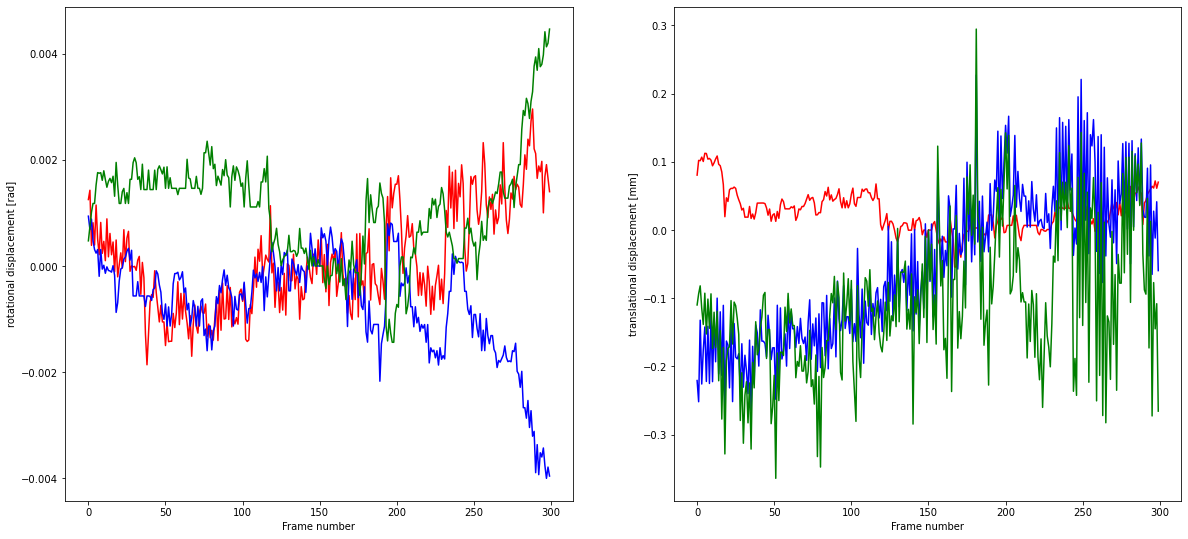

In [32]:
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec

#Plot 3 rotational and 3 translational motion parameter
lines = open(realign_params, 'r').readlines()
rows = [[float(x) for x in line.split()] for line in lines]
cols = np.array([list(col) for col in zip(*rows)])

fig = Figure(figsize=(20,20))
grid = GridSpec(2, 2) 
ax = fig.add_subplot(grid[0:1,0])
ax.plot(cols[0, :], color="red")
ax.plot(cols[1, :], color="blue")
ax.plot(cols[2, :], color="green")
ax.set_ylabel("rotational displacement [rad]")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[0:1,1])
ax.plot(cols[3, :], color="red")
ax.plot(cols[4, :], color="blue")
ax.plot(cols[5, :], color="green")
ax.set_ylabel("translational displacement [mm]")
ax.set_xlabel("Frame number")
fig

From the rotational parameters, we see that the subject turned its head very subtly to the right throughout the scan (blue rotational parameters indicating rotation around y-axis called roll). This can be best seen when comparing early & late volumes.
From the translational parameters, we see that he/she performed up-down movements (green translational parameter indicating movement in the z-direction). There was little displacement in x-direction (red translational parameter), and some displacement in the y-direction in the first half of the scan (blue translational parameter).
We can summarize these motion parameters using Framewise displacement, a measure adding the total displacement from frame to frame. See the [original publication](https://pubmed.ncbi.nlm.nih.gov/22019881) for more details.

In [34]:
from nipype.algorithms.confounds import FramewiseDisplacement

FrameDisp=FramewiseDisplacement()
FrameDisp.inputs.in_file=realign_params
FrameDisp.inputs.out_file="./fMRI_data/sub-160563d/func/power_fd.txt"
FrameDisp.inputs.parameter_source="FSL"
res_FD=FrameDisp.run()

#to bring the FD into a "plot-table" object
FD= open(res_FD.outputs.out_file, 'r').readlines()
#print(FD[1:])
FD_rows = [[float(x) for x in line.split()] for line in FD[1:]]
FD_cols = np.array([list(col) for col in zip(*FD_rows)])
FD_for_plot=np.insert(FD_cols,0,0)
#print(FD_for_plot)

In [35]:
print(res_FD.outputs)


fd_average = 0.21766871291973247
out_figure = <undefined>
out_file = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/power_fd.txt



#### Exercise 4
What is the average Framewise displacement across the scan?

We now compare the motion parameters to the global signal (GS). This is the average of all voxels intensities over time. We compute it with a `nilearn` function which masks the data and returns the masked data in a flat array. Then, we take the average of this array along the second dimension.

In [36]:
from nilearn.masking import apply_mask
import numpy as np

masked_data = apply_mask('./fMRI_data/sub-160563d/func/rest_mcf.nii.gz', 
                         './fMRI_data/sub-160563d/func/rest_mcf_mean_brain_mask.nii.gz')
GS=np.mean(masked_data,axis=1)


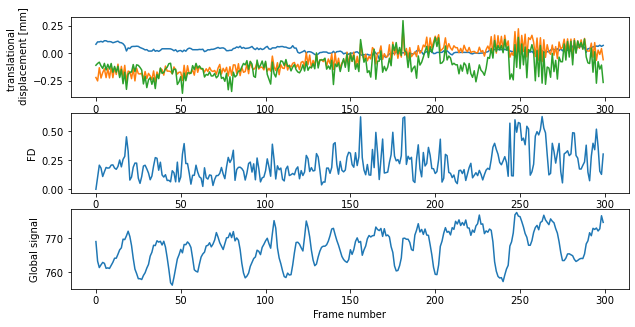

In [38]:
fig = Figure(figsize=(10,5))
grid = GridSpec(3,1) 
ax = fig.add_subplot(grid[0,0])
ax.plot(cols[3, :])
ax.plot(cols[4, :])
ax.plot(cols[5, :])
ax.set_ylabel("translational \n displacement [mm]")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[1,0])
ax.plot(FD_for_plot)
ax.set_ylabel("FD")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[2,0])
ax.plot(GS)
ax.set_ylabel("Global signal")
ax.set_xlabel("Frame number")
fig

We see that there is a periodic variation in the global signal. Let's calculate its frequency!

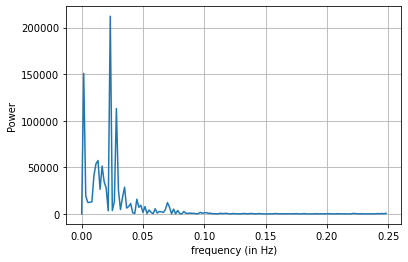

In [39]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = 300
# sample spacing (repetition time)
T = 2.0 

x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(0.02 * 2.0*np.pi*x) + 0.8*np.sin(0.01 * 2.0*np.pi*x)
y=GS-np.mean(GS)

yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, np.abs(yf[0:N//2])**2)
plt.xlabel("frequency (in Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()

The low-intensity frequencies in this fMRI timeseries fall in the frequency range of neuronal fluctuations (0.01 - 0.1 Hz). Yet, there may still be noise components inside (stemming from aliasing of higher-frequency signals (respiration & cardiac pulsation), sympathetic nervous system tone, partial pressure of carbon dioxide (paCO2) fluctuations modulated by respiration, blood pressure regulation, low frequency neuronal “waves,” and even gastric motility [Reference](https://www.frontiersin.org/articles/10.3389/fnins.2019.00787/full).) 

Another important diagnostic measure is the temporal derivative of the GS. DVARS is taking the temporal **D**erivative, then calculating the RMS **VAR**iance over element**S**. DVARS is informative about volumes with large signal intensity changes, e.g. due to motion or instrument artifact.  
It can be used to identify problematic volumes for later scrubbing or censoring (e.g. excluding the volumes for further analyses or using them as regressors on the first-level).   
The `ComputeDVARS` function returns both the unstandardized DVARS (scaled to 1000 leading to the units being expressed in x10 %ΔBOLD change) and standardized DVARS (normalized with the standard deviation of the temporal difference time series). For more information on which measure and criteria to apply to scrub volumes based on DVARS, please see [this publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5915574/). 

In [40]:
from nipype.algorithms.confounds import ComputeDVARS

computeDvars = ComputeDVARS()
computeDvars.inputs.in_file = './fMRI_data/sub-160563d/func/rest_mcf.nii.gz'
computeDvars.inputs.in_mask ='./fMRI_data/sub-160563d/func/rest_mcf_mean_brain_mask.nii.gz'
#computeDvars.outputs.out_all='./fMRI_data/sub-010088/preproc/
res_DVARS = computeDvars.run() 

#move the output to the other preprocessing outputs
!mv rest_mcf_dvars_std.tsv fMRI_data/sub-160563d/func

#to have DVARS as plottable object
DVARS= open('./fMRI_data/sub-160563d/func/rest_mcf_dvars_std.tsv', 'r').readlines()
DVARS_rows = [[float(x) for x in line.split()] for line in DVARS]
DVARS_cols = np.array([list(col) for col in zip(*DVARS_rows)])
DVARS_for_plot=np.insert(DVARS_cols,0,0)


Now, let's plot all metrics together

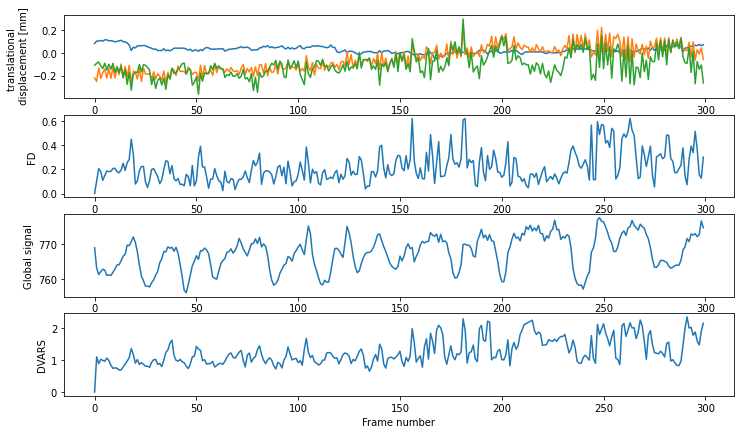

In [41]:
fig = Figure(figsize=(12,7))
grid = GridSpec(4,1) 
ax = fig.add_subplot(grid[0,0])
ax.plot(cols[3, :])
ax.plot(cols[4, :])
ax.plot(cols[5, :])
ax.set_ylabel("translational \n displacement [mm]")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[1,0])
ax.plot(FD_for_plot)
ax.set_ylabel("FD")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[2,0])
ax.plot(GS)
ax.set_ylabel("Global signal")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[3,0])
ax.plot(DVARS_for_plot)
ax.set_ylabel("DVARS")
ax.set_xlabel("Frame number")
fig

We see that for some volumes (around frame 180, 250) FD and DVARS peaks coincide. Yet, the global signal does not seem particularly off. This difference is due to the fact that DVARS reflects *variability* of the temporal derivative over voxels, while the global signal is the mean of all voxels. Thus, it is possible that the intensity changes strongly in some voxels, but not at all or only slightly in the majority of all voxels.  
To further explore the appearance of confounds in the data, **carpet plots** are extremely valuable. They show the gray values of each voxel (or brain region) for each timepoint. Here, we do not have the anatomical segmentation yet, but we can plot all voxels individually.

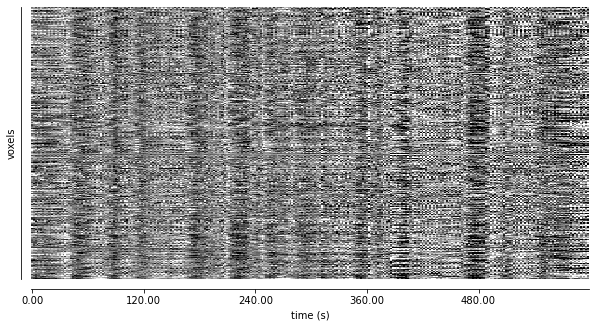

In [33]:
%matplotlib inline
from nilearn.plotting import plot_carpet

display = plot_carpet(func, mask_img)

display.show()

Here, we see that actually most voxels show dark bands. This speaks against the low-frequency fluctuations being of neuronal origin, as only GM voxels should show this pattern then. We also see that the global drop in signal around frame 240 (time 480s) is not really related to motion parameters, and may thus be caused by respiration, such as a deep inhale.

#### Small excursion about other carpet plots
[Carpet plots](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5296400/) combined with head motion parameters, DVARS and if available, physiological data (such as recordings from respiration belts or pulse oxiymetry) are a great tool to investigate confounders in your fMRI data. 
The carpet plot function is implemented in [fmriprep](https://fmriprep.readthedocs.io/en/stable/usage.html) and [mriqc](https://mriqc.readthedocs.io/en/latest/). See this presentation by [J. Power](https://www.pathlms.com/ohbm/courses/5158/sections/7788/video_presentations/75974), the inventor of *the plot*, on the interpretation.   
Below you see three examples from another study, where the carpet shows the signal from voxels in GM (red), WM (green), CSF (orange) & cerebellum (blue). 
![Example 1](summary_fmriplot_good_example.png)
![Example 2](summary_fmriplot_intermediate.png)
![Example 3](summary_fmriplot_bad_example.png)

#### Exercise 5
Import the function `plot_frame_displacement` from the file `motion.py` and use it to plot FD and DVARS together

## 3.1 Noise regression
Including motion parameters (as well as their first and second derivatives) or physiological confounders into resting state and task-based fMRI analyses is commonly accepted. Yet, this is often not **sufficient** (especially for resting state fMRI) to remove unwanted variance. For more information, see these publications which compared different resting state preprocessing strategies by [Parkes](https://www.sciencedirect.com/science/article/pii/S1053811917310972) & [Ciric](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5483393/).  
GS regression is an effective way to perform motion correction (as described in the publications above). Yet, it also has the downside of introducing spurious, negative correlations, and introduces a distance-dependence in the connectivity between brain regions.See here for a [consensus statement](https://www.sciencedirect.com/science/article/pii/S1053811916306711) on the usage of GS regression.  
Let's create a node which performs a linear regression to remove the six motion parameters and GS from the rs fMRI. A node works in a working directory (`/tmp`), therefore we specify full paths to the input.

In [42]:
#Use 3 rotational and 3 translational motion parameter AND the global signal as regressors
rp=np.loadtxt(realign_params)
comb=np.hstack((rp,np.reshape(GS,(np.shape(rp)[0],1))))
np.savetxt('./fMRI_data/sub-160563d/func/all_regressors.txt',comb)
                     
filter2 = Node(fsl.GLM(demean=True,
                       out_f_name='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/F_noise.nii.gz',
                       out_pf_name='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/pF_noise.nii.gz',
                       out_res_name='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_denoised.nii.gz',
                       output_type='NIFTI_GZ',
                       ), 
                       name='filternoise')
filter2.plugin_args = {'submit_specs': 'request_memory = 17000'}
filter2.inputs.design='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/all_regressors.txt'#./fMRI_data/sub-010088/preproc/all_regressors.txt'
filter2.inputs.in_file='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf.nii.gz'                        
filter2.inputs.mask= '/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain_mask.nii.gz'
res_denoise=filter2.run()

210610-07:43:03,972 nipype.workflow INFO:
	 [Node] Setting-up "filternoise" in "/tmp/tmpdc3k7fis/filternoise".
210610-07:43:03,996 nipype.workflow INFO:
	 [Node] Running "filternoise" ("nipype.interfaces.fsl.model.GLM"), a CommandLine Interface with command:
fsl_glm -i /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf.nii.gz -d /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/all_regressors.txt -o rest_mcf_glm.nii.gz --demean -m /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain_mask.nii.gz --out_f=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/F_noise.nii.gz --out_pf=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/pF_noise.nii.gz --out_res=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_denoised.nii.gz
210610-07:43:08,373 nipype.workflow INFO:
	 [Node] Finished "filternoise".


In [43]:
print(res_denoise.outputs)


out_cope = <undefined>
out_data = <undefined>
out_f = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/F_noise.nii.gz
out_file = /tmp/tmpdc3k7fis/filternoise/rest_mcf_glm.nii.gz
out_p = <undefined>
out_pf = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/pF_noise.nii.gz
out_res = /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_denoised.nii.gz
out_sigsq = <undefined>
out_t = <undefined>
out_varcb = <undefined>
out_vnscales = <undefined>
out_z = <undefined>



Let's take a look at the functional image and the carpet plot after denoising. The functional image is now centered around 0, that's why it does not contrast with the background. In the carpet plot, we see that the stripy pattern going over all voxels has disappeared.

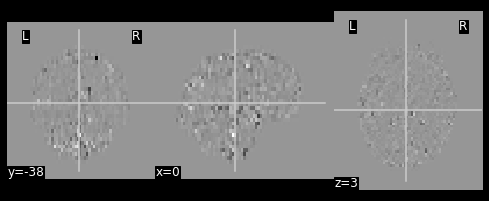

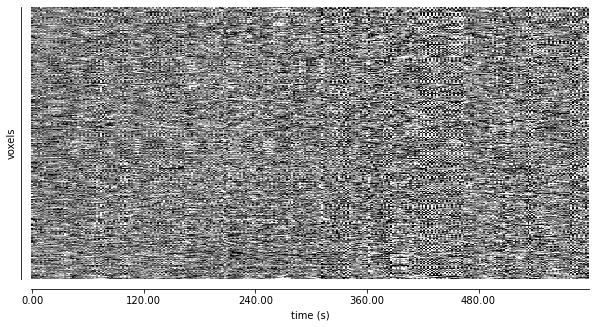

In [44]:
%matplotlib inline
from nilearn.image.image import mean_img
plot_epi(mean_img(res_denoise.outputs.out_res), cmap="gray")

from nilearn.plotting import plot_carpet
display = plot_carpet(res_denoise.outputs.out_res, mask_img)
display.show()

Let's extract the "new" GS after the regression to compare it to the "pre"-denoised GS.

In [45]:
masked_data_after_regr = apply_mask('/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_denoised.nii.gz', 
                         '/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain_mask.nii.gz')
print(np.shape(masked_data_after_regr))
GS_after_regression=np.mean(masked_data_after_regr,axis=1)

(300, 33658)


We load the undenoised and denoised data to compare individual voxel timecourses. 
I selected the voxel [32,23,19] (located in the precuneus), but feel free to try out other voxel locations. You can use the interactive viewer to get their coordinates.

In [46]:
img_func_bef_denoising=nib.load('/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf.nii.gz')
img_func_bef_denoising_data=img_func_bef_denoising.get_fdata()

In [47]:
img_func_denoised=nib.load('./fMRI_data/sub-160563d/func/rest_denoised.nii.gz')
img_func_denoised_data=img_func_denoised.get_fdata()

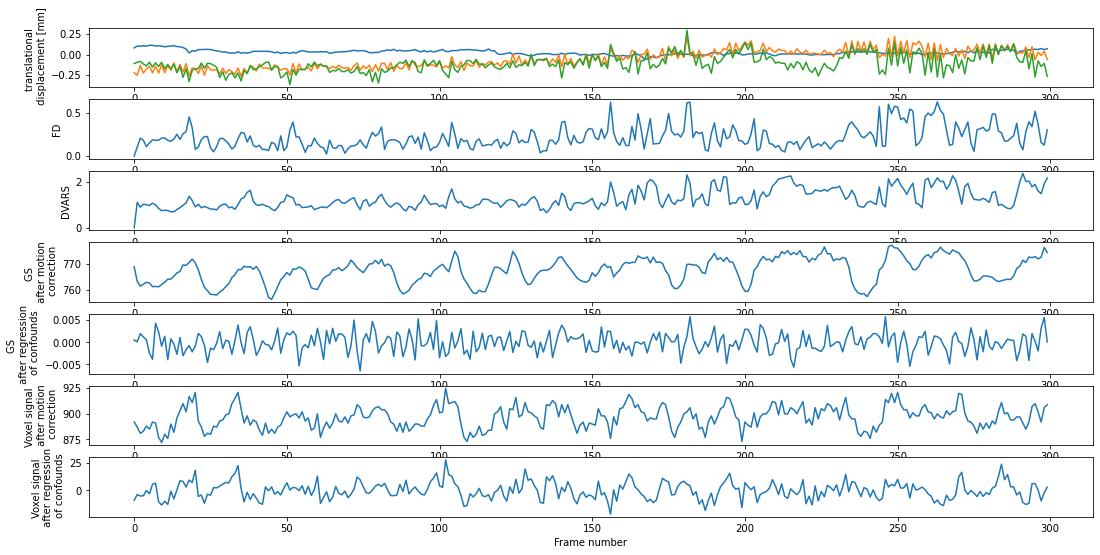

In [48]:
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
fig = Figure(figsize=(18,9))
grid = GridSpec(7,1) 
ax = fig.add_subplot(grid[0,0])
ax.plot(cols[3])
ax.plot(cols[4])
ax.plot(cols[5])
ax.set_ylabel("translational \n displacement [mm]")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[1,0])
ax.plot(FD_for_plot)
ax.set_ylabel("FD")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[2,0])
ax.plot(DVARS_for_plot)
ax.set_ylabel("DVARS")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[3,0])
ax.plot(GS)
ax.set_ylabel("GS \n after motion \n correction")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[4,0])
ax.plot(GS_after_regression)
ax.set_ylabel("GS \n after regression \n of confounds")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[5,0])
ax.plot(img_func_bef_denoising_data[32,23,19,:])
ax.set_ylabel("Voxel signal \n after motion \n correction")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[6,0])
ax.plot(img_func_denoised_data[32,23,19,:])
ax.set_ylabel("Voxel signal \n after regression \n of confounds")
ax.set_xlabel("Frame number")
fig

We see that after regressing the motion parameters and the global signal, our GS is shifted from around 700 to 0 (compare rows 4 & 5). This is because the denoised data are the **residuals** of the linear regression - and by definition centered around 0. Also, we see that the timeseries is actually *less* smooth - this is becaused we regressed the orange & green timeseries which contain much higher frequency noise.   
Also, from rows 6 & 7 we see that the individual voxel timeseries is changed rather subtly by the denoising procedure. Yet, as shown by the carpet plots, the global signal fluctuations (frame number ~ 250) are reduced. To further improve the denoising procedure, we could also include the average signal of the WM or CSF, or temporal derivatives of motion parameters.  
##### How to evaluate the denoising performance?
This is a very difficult question. For task-based fMRI, I am not aware of any formal checks - but as you explicitely model the activity based on external cue, you are usually on the safe side including the main motion parameters. For resting state fMRI, some hints are given [here](https://experiments.springernature.com/articles/10.1038/s41596-018-0065-y): it is recommended to check the motion - functional connectivity correlation (less is better) and the distance-dependence of the FC (less is better). 

 <font color='grey'> 
Let's take a closer look to better understand the denoising outputs. First we plot the pre-and post denoising data for our favorite voxel. We see that they are still highly correlated (which we would expect given the plots above).  

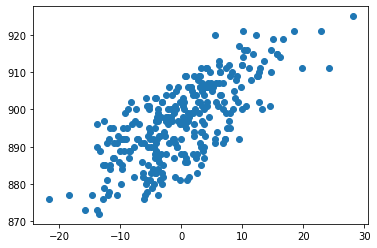

In [49]:
plt.scatter(img_func_denoised_data[32,23,19, :], img_func_bef_denoising_data[32,23,19, :])

The correlation of the timeseries before denoising and the global signal is also very high, indicating a high level of noise.

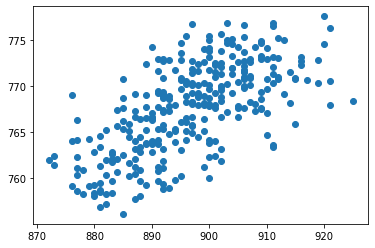

In [50]:
plt.scatter(img_func_bef_denoising_data[32,23,19, :],GS)

#### Exercise 6 : What do you expect (in terms of correlation) if you plot the denoised voxel data against the GS? Please create the plot and explain to each other.

# Thank you for your participation! I hope you had fun.